Try the super-naive rate-based model
$\tau_L \dot{r}_i = r^0_{i} - r_i + \frac{W_{ij}r_j + W^I_{i}r^I_i}{V^T_i - V^0_i}$, 
where
* $r_i$ is the spike rate of neuron
* $r^0_{i}$ is the steady state firing rate
* $\tau_L$ is the neuron relaxation time
* $V^0_i$ is the baseline membrane potential
* $V^T_i$ is the firing threshold membrane potential
* $W_{ij}$ is the connection weight between neurons $i$ and $j$ (Volt/Spike)
* $W^I_{i}$ is the external input weight (Volt/Spike)
* $r^I_{i}$ is the external input spike rate

Cellular homeostatic plasticity can be modelled as $\dot{V}^T_i = -\alpha_{CHP} (r^{T}_{i} - r_i)$, where
* $\alpha_{CHP}$ is the CHP rate
* $r^{T}_{i}$ is the typical firing rate

Synaptic STDP plasticity can be modelled as $\dot{W_{ij}} = \alpha_{STDP} (R_i^{t}R_j^{t+\Delta t} - R_i^{t}R_j^{t+\Delta t})$, where
* $\alpha_{STDP}$ is the STDP rate
* $R_i = r_i - r^{T}_{i}$ is the spike rate, compared to typical spike rate


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from aux import subplots1D

%load_ext autoreload

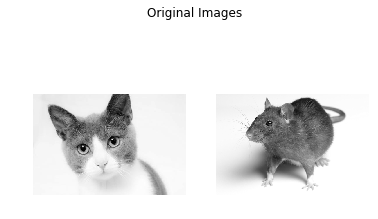

In [2]:
# Load raw images
# img1 = (mpimg.imread('../img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('../img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat2.png')
img2 = mpimg.imread('../img/rat2.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images');

10.0


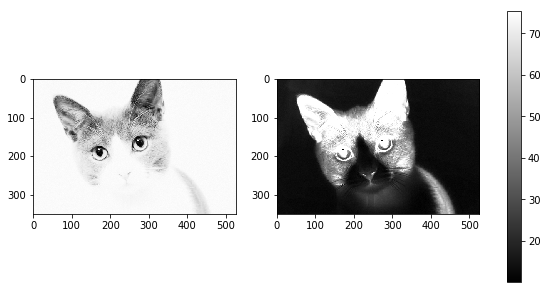

In [34]:
def clipArr(arr, rng):
    arr[arr < rng[0]] = rng[0]
    arr[arr > rng[1]] = rng[1]
    return arr

def nextState(r, r0, rI, WI, rRange, tauL, noise_std, dt):
    noise = np.random.normal(0, noise_std, len(r))
    rNew = r + (r0 - r + np.multiply(WI, rI) + noise) * (dt / tauL)
    return clipArr(rNew, rRange)

def nextThrW(WI, r, rT, WIRange, HP_RATE, dt):
    return clipArr(WI + (rT - r) * HP_RATE * dt, WIRange)
    
N_NEURON = img1.shape[0] * img1.shape[1]
INPUT_RATE = 100.0 # Hz
INPUT_WEIGHT = 0.3 # parts of threshold per presynaptic spike
INPUT_WEIGHT_RANGE = [0.05, 2.0]
NEURON_RATE_RANGE = [10.0, 100.0] #Hz
NEURON_RELAX_TIME = 10.0 # ms
NEURON_RATE_TYPICAL = 50.0 # Hz
NOISE_RATE_STD = 5.0 # Hz
HP_RATE = 0.01 # Volts per spike^2
DT = 0.1 # ms

INPUT_RATE_CAT = INPUT_RATE * np.ndarray.flatten(img1)
r = NEURON_RATE_RANGE[0] * np.ones(N_NEURON)
r0 = NEURON_RATE_RANGE[0] * np.ones(N_NEURON)
WI = INPUT_WEIGHT * np.ones(N_NEURON)

print(NEURON_RELAX_TIME)

for i in range(100):
    r = nextState(r, r0, INPUT_RATE_CAT, WI, NEURON_RATE_RANGE, NEURON_RELAX_TIME, NOISE_RATE_STD, DT)
    WI = nextThrW(WI, r, NEURON_RATE_TYPICAL, INPUT_WEIGHT_RANGE, HP_RATE, DT)
    
fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
plot0 = ax[0].imshow(np.reshape(r, img1.shape), cmap='gray')
plot1 = ax[1].imshow(np.reshape(WI, img1.shape), cmap='gray')

fig.colorbar(plot0, ax=ax.ravel().tolist())
plt.show()

**TEST 2:** Try to do local WTA network (aka Mexican Hat Inhibition).
* Make 1000 neurons on a 1D line
* +/- 5 neurons are excited with a positive triange.
* +/- 10 neurons are excited with a negative triange, that has larger area.

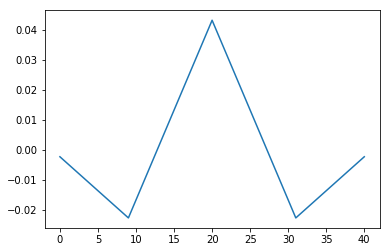

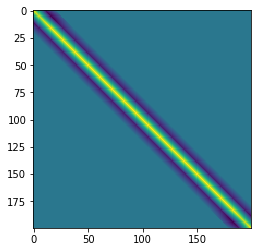

In [126]:
def triangle(delta, area):
    rez = np.zeros(2*delta + 3)
    rez[0:delta+2] = np.linspace(0, 1, delta + 2)
    rez[delta+1:2*delta+3] = np.linspace(1, 0, delta + 2)
    return (rez / np.sum(rez) * area)[1:-1]

def hat(delta1, delta2):
    rez = -triangle(delta2, 1)
    rez[delta2-delta1:delta2+delta1+1] += triangle(delta1, 1)
#     rez[delta2] = 0
    return rez

# Make a mexican hat
RANGE1 = 10
RANGE2 = 20
hat1 = hat(RANGE1, RANGE2)

plt.figure()
plt.plot(hat(10,20))
plt.show()

# Make a matrix of mexican hats
N_NEURON = 200

mat = np.zeros((N_NEURON, N_NEURON+2*RANGE2))
for i in range(0, N_NEURON):
    mat[i, i:i + 2*RANGE2 + 1] = hat1
mat = mat[:,RANGE2:-RANGE2]

# Normalize sum for each row to ensure excitatory-inhibitory balance
for row in mat:
    row[row != 0] -= np.sum(row[row != 0]) / len(row[row != 0])
    
plt.figure()
plt.imshow(mat)
plt.show()

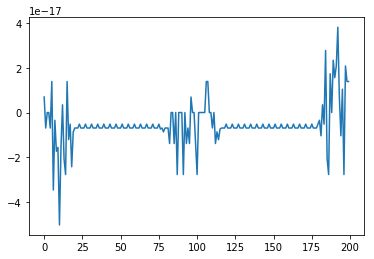

In [127]:
plt.figure()
plt.plot(np.sum(mat, axis=1))
plt.show()

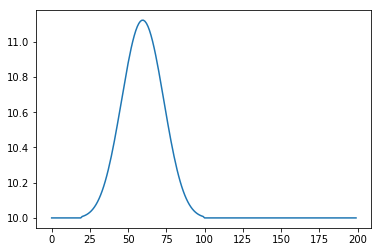

In [163]:
from scipy import signal

def nextState(r, r0, rI, WI, W, rRange, tauL, noise_std, dt):
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, len(r))
    else:
        noise = np.zeros(len(r))

    rNew = r + (r0 - r + np.multiply(WI, rI) + W.dot(r) + noise) * (dt / tauL)
    return clipArr(rNew, rRange)

r = NEURON_RATE_RANGE[0] * np.ones(N_NEURON)
r0 = NEURON_RATE_RANGE[0] * np.ones(N_NEURON)
WI = 1 * np.ones(N_NEURON)
rI_A = np.zeros(N_NEURON)
rI_B = np.zeros(N_NEURON)
rI_A[20:100] = signal.gaussian(80, std=15)

for i in range(1000):
    r = nextState(r, r0, rI_A, WI, mat, NEURON_RATE_RANGE, NEURON_RELAX_TIME, 0, DT)

for i in range(0):
    r = nextState(r, r0, rI_B, WI, mat, NEURON_RATE_RANGE, NEURON_RELAX_TIME, 0, DT)

plt.figure()
plt.plot(r)
plt.show()